In [ ]:

Visualizing yeast chromosomes distributions in the w2v embedding space.

In [24]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import seqloops.config as cfg
import tokenizers as tok
import matplotlib.pyplot as plt
from Bio import SeqIO

In [12]:
embedding = KeyedVectors.load_word2vec_format(
    cfg.embedding,
    binary=False,
)
tokenizer = tok.Tokenizer(tok.models.BPE())
tokenizer = tokenizer.from_file(str(cfg.tokenizer))

In [45]:
def process_seq(seq: str, chunksize=500) -> "np.ndarray":
    """Chunk input sequence, tokenize and embed chunks"""
    chunks = [
        seq[i:i+chunksize] for i in range(0, len(seq), chunksize)
    ]
    chunks = [tokenizer.encode(chunk).tokens for chunk in chunks]
    embedded = np.zeros((len(chunks), embedding.vector_size))
    for i, chunk in enumerate(chunks):
        valid_words = 0
        for word in chunk:
            if embedding.has_index_for(word):
                embedded[i, :] += embedding.get_vector(word)
                valid_words += 1
        embedded[i, :] /= valid_words

    return embedded

chroms = {}
for rec in SeqIO.parse(cfg.genome, 'fasta'):
    chroms[rec.id] = pd.DataFrame(process_seq(str(rec.seq)))
    chroms[rec.id]['chrom'] = rec.id
chroms = pd.concat(chroms.values())

In [79]:
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
pcs = PCA().fit_transform(chroms.drop(columns=['chrom']))

/home/varogh/anaconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'PCA of yeast genome w2v embedding')

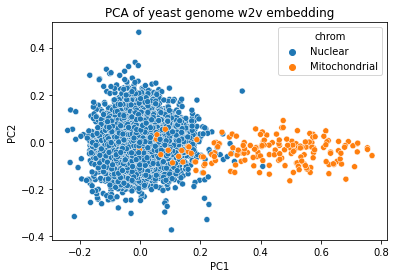

In [81]:
%matplotlib inline
# Picking some interesting chromosomes to compare
focus = chroms['chrom'].isin(['chrM'])
chrom_col = chroms.chrom.copy()
chrom_col[focus] = 'Mitochondrial'
chrom_col[~focus] = 'Nuclear'
#sns.scatterplot(umap[~focus, 0], umap[~focus, 1], color='gray')
sns.scatterplot(pcs[:, 0], pcs[:, 1], hue=chrom_col)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of yeast genome w2v embedding")